# Parsing Annotations into COCO (masks, categories)

In [49]:
# import some common libraries
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import random
import os
import numpy as np
import json


from pycocotools.coco import COCO
import glob
import base64
import io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
from PIL import Image
import pycocotools
from skimage import measure
import json
from IPython.core.display import display, HTML

from wordcloud import WordCloud
pd.set_option('max_colwidth', 300)
matplotlib.rcParams['figure.figsize'] = (20, 7.0)

display(HTML(
    """
    <style>
    .container { width:100% !important; }
    #notebook { letter-spacing: normal !important;; }
    .CodeMirror { font-family: monospace !important; }
    .cm-keyword { font-weight: bold !important; color: #008000 !important; }
    .cm-comment { font-style: italic !important; color: #408080 !important; }
    .cm-operator { font-weight: bold !important; color: #AA22FF !important; }
    .cm-number { color: #080 !important; }
    .cm-builtin { color: #008000 !important; }
    .cm-string { color: #BA2121 !important; }
    </style>
    """
))

* #### Set `mask_annotations_f` to the path of the csv file with batch results form a mturk mask annotation task
* #### Set `tags_f` to the path of the csv file with batch results form a mturk class labeling task
* #### Set `out_f` to output annotations file name
* #### Run All

In [54]:
tags_f = 'properties_data_habitat_mar2021.csv'
mask_annotations_f = 'masks_habitat_mar2021.csv'
out_f = 'habitat_coco_annos.json'

### WordCloud of all category labels 

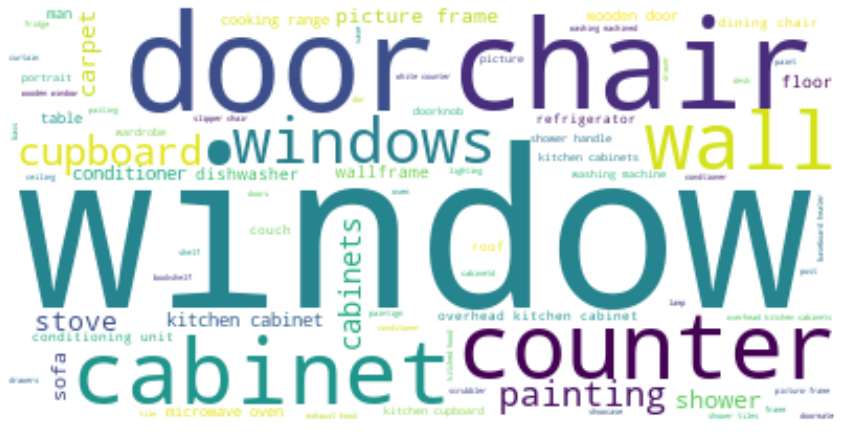

In [3]:
from collections import OrderedDict
from operator import itemgetter
import re

p = dict()

tags_df = pd.read_csv(tags_f)
tags_df = tags_df.loc[tags_df['Answer.tag1'] != "Picture won't load"]
tags_df = tags_df[1:]

for _, row in tags_df.iterrows():
    if row['Answer.tag1'] != "Picture won't load":
        label = row['Answer.tag1'].lower()
        label =  ' '.join([word for word in label.split() if not re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", word)])
        if label in p.keys():
            p[label] += 1
        else:
            p[label] = 1
    
od = OrderedDict(sorted(p.items(), key=lambda x:x[1], reverse=True))

## Uncomment to look at raw counts
# print("{:<8} {:<15}".format('Label','Count'))
# for k, v in od.items():
#     print("{:<8} {:<15}".format(k, v))

def makeImage(text):
    wc = WordCloud(background_color="white", max_words=100)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.figure(figsize=(15,15))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

makeImage(od)

### Combine similar object classes into one

In [13]:
# Reduce redunancies - window and windows are the same thing
import krovetz
from fuzzywuzzy import process, fuzz

class LabelIdGenerator:
    def __init__(self):
        self.label_id = dict()
        self.ctr = 1
        self.ks = krovetz.PyKrovetzStemmer()
        
    def get_id_for_label(self, label):
        if label == '':
            return 
        if label in self.label_id.keys():
            return self.label_id[label]
    
        # Check if this label reduces to something already
        if len(label.split()) == 1:
            label = self.ks.stem(label)
#             print("Stemming {}, {}".format(label, self.ks.stem(label)))
        
        b = process.extractOne(label, self.label_id.keys(), scorer=fuzz.token_set_ratio)
#         print("best match for {} : {}".format(label, b))
        
        if b is None or b[1] < 100:
            self.label_id[label] = self.ctr
            self.ctr += 1
            return self.label_id[label]
        else:
            print("{} matched to {}".format(label, b))
            return self.label_id[b[0]]
    
    def get_label_id_dict(self):
        return self.label_id
        

lg = LabelIdGenerator()
for k, v in od.items():
    lg.get_id_for_label(k)

print(lg.get_label_id_dict())

window matched to ('window', 100)
cabinet matched to ('cabinet', 100)
kitchen cabinet matched to ('cabinet', 100)
wooden door matched to ('door', 100)
dining chair matched to ('chair', 100)
overhead kitchen cabinet matched to ('cabinet', 100)
picture matched to ('picture frame', 100)
kitchen cupboard matched to ('cupboard', 100)
shower handle matched to ('shower', 100)
door matched to ('door', 100)
shower tiles matched to ('shower', 100)
oven matched to ('microwave oven', 100)
wooden window matched to ('window', 100)
slipper chair matched to ('chair', 100)
white counter matched to ('counter', 100)
frame matched to ('picture frame', 100)
overhead kitchen cabinets matched to ('kitchen cabinets', 100)
{'window': 1, 'door': 2, 'chair': 3, 'counter': 4, 'cabinet': 5, 'wall': 6, 'cupboard': 7, 'painting': 8, 'stove': 9, 'carpet': 10, 'shower': 11, 'picture frame': 12, 'sofa': 13, 'condition': 14, 'floor': 15, 'wallframe': 16, 'dishwasher': 17, 'microwave oven': 18, 'cooking range': 19, 'tabl

## Create COCO Annotations

In [41]:
def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    hlen = len(hex)
    return tuple(int(hex[i:i+hlen // 3], 16) for i in range(0, hlen,hlen//3))

def decode_png(dat):
    byt = base64.b64decode(str(dat))
    img = Image.open(io.BytesIO(byt))
    return img

def get_filtered_id(labels):
    # Returns IDs for label
    for x in labels:
        return lg.get_id_for_label(x)
    print("No id for {}".format(labels))
    return -1

def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

def binary_mask_to_polygon(binary_mask, tolerance=0):
    """Converts a binary mask to COCO polygon representation
    Args:
        binaaary_mask: a 2D binary numpy array where '1's represent the object
        tolerance: Maximum distance from original points of polygon to approximated
            polygonal chain. If tolerance is 0, the original coordinate array is returned.
    """
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation 
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)

    return polygons

def get_key(filename, col):
    return filename.replace(".jpg", "") + col.replace("#", "%23") + ".png"

def lookup_tag1(filename, col):
    key = get_key(filename, col)
    labels = []
    properties = set()
    for _, row in tags_df.iterrows():
        url = row['Input.image_url']
        url = url.split('/')[-1]
        if key == url:
#             print(key, url)
            labels.append(row['Answer.tag1'].lower())
            properties.add(row['Answer.tag2'].lower())
            properties.add(row['Answer.tag3'].lower())
    return labels, list(properties)

def select_object_classes(mask, instances, filename):
    # return <mask, label> pairs
    # translate hex color to label 
    masks = []
    print("Selecting objects for file {}".format(filename))
    for d in instances:
        # get name for each hex color
        col = d['color']
        l, p = lookup_tag1(filename, col)
        labels = l if d['label'] == 'Object' else [d['label'].lower()]
        img_c = mask.convert('RGB').copy()
        img = mask.copy()
        for x in range(img.size[0]):
            for y in range(img.size[1]):
                if img_c.getpixel((x,y)) != hex_to_rgb(col):
                    img.putpixel((x,y), 0)

#             print("labels {}".format(labels))
#             img.show()
        masks.append((img, labels, p))
    
    return masks

uniq_id = 1

def make_coco_annotations(mask, category_id, img_id):
    if category_id == -1:
        return {}
    mask = np.array(mask)
    ids = np.unique(mask)[1:]
    masks = mask == ids[:, None, None]
    num_masks = len(ids)
#     print("num_masks", num_masks)
    annotations = []
    global uniq_id
    for i in range(num_masks):
        anno = {}
        binary_mask_encoded = pycocotools.mask.encode(np.asfortranarray(masks[i].astype(np.uint8)))
        anno['bbox'] = pycocotools.mask.toBbox(binary_mask_encoded).tolist()
        anno['segmentation'] = binary_mask_to_polygon(masks[i])
#         mask.encode(np.asarray(masks[i], dtype=np.uint8, order="F"))
        anno['area'] = float(pycocotools.mask.area(binary_mask_encoded))
        anno['iscrowd'] = 0
        anno['category_id'] = category_id
        anno['id'] = uniq_id
        uniq_id += 1
        anno['image_id'] = int(img_id.split('.')[0])
        annotations.append(anno)
        print("image_id", anno['image_id'])
    
    return annotations

def get_default_properties(labels):
    if 'chair' in labels:
        k = 'chair'
        l = ['gray', 'mesh-rear', 'comfortable', 'wheeled', 'moveable']
    elif 'monitor' in labels:
        k = 'monitor'
        l = ['electronic', 'plastic', 'flat', 'shiny', 'rectangle']
    elif 'desk' in labels:
        k = 'desk'
        l = ['solid', 'flat', 'wood', 'white']
    for x in l:
        sp_update(pdict, x)
#     print('k {}, v {}, pdict {}'.format(k,l,pdict))
    return l

files = set()

def convert_turk_annotations_to_coco_v2(results):
    df = pd.read_csv(results)
    df['Answer.annotatedResult.instances'] = df['Answer.annotatedResult.instances'].apply(literal_eval)
    display(df['Input.image_url'].head(2))
    print("Number of rows {}".format(len(df)))
    annotations = []
    ctr = 0
    global uniq_id 
    uniq_id = 1
    # one row per HIT, two rows per image 
    for _, row in df.iterrows():
        ctr = ctr + 1
        mask_anno = row['Answer.annotatedResult.labeledImage.pngImageData']
        instances = row['Answer.annotatedResult.instances']
        filename = str(row['Input.image_url']).split('/')[-1]
        files.add(filename)
        mask_img = decode_png(mask_anno)
        mask_labels = select_object_classes(mask_img.copy(), instances, filename)
        for mask, labels, p in mask_labels:
            if labels:
                annos = make_coco_annotations(mask, get_filtered_id(labels), filename)
                for a in annos:
                    if not p:
                    # FIXME: Add properties to the dataset as well
                        p = get_default_properties(labels)
#                         print("defaults {}".format(p))
#                     a['properties'] = [pdict[x] for x in p]
#                     print("a[prop] {}".format(a["properties"]))
                    print("Label {}, properties {}".format(labels, p))
                for a in annos:
                    annotations.append(a)
        print("Total {} annos until url {}".format(len(annotations), row['Input.image_url']))
#         break
    
    return annotations


tags_df = pd.read_csv(tags_f)
tags_df = tags_df.loc[tags_df['Answer.tag1'] != "Picture won't load"]
annotations = convert_turk_annotations_to_coco_v2(mask_annotations_f)

0    https://locobot-bucket.s3-us-west-2.amazonaws.com/ActiveVisionDatasets/habitat_turk_data/00000.jpg
1    https://locobot-bucket.s3-us-west-2.amazonaws.com/ActiveVisionDatasets/habitat_turk_data/00060.jpg
Name: Input.image_url, dtype: object

Number of rows 95
Selecting objects for file 00000.jpg
a chair matched to ('chair', 100)
image_id 0
Label ['a chair', 'chair'], properties ['black', 'dark brown', 'sitting', 'thin']
a chair matched to ('chair', 100)
image_id 0
Label ['a chair', 'chair'], properties ['dark colored', 'wooden', 'slim', 'painted']
Total 2 annos until url https://locobot-bucket.s3-us-west-2.amazonaws.com/ActiveVisionDatasets/habitat_turk_data/00000.jpg
Selecting objects for file 00060.jpg


/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


window matched to ('window', 100)
image_id 60
Label ['windows', 'window'], properties ['square shape', 'covered by blind', 'beige cloth', 'glass windows']
image_id 60
Label ['window', 'windows'], properties ['heat resistant', 'transparent glass', 'white', 'closed']
image_id 60
Label ['chair', 'chair'], properties ['man made', 'soft cushion', 'wood', 'metal body']
image_id 60
Label ['chair', 'chair'], properties ['white', 'brown', 'hard', 'dark colors']
image_id 60
Label ['chair', 'dining chair'], properties ['sitting', 'dark painted', 'comfortable', 'metal body']
Total 7 annos until url https://locobot-bucket.s3-us-west-2.amazonaws.com/ActiveVisionDatasets/habitat_turk_data/00060.jpg
Selecting objects for file 00120.jpg
image_id 120
Label ['window', 'windows'], properties ['square windows', 'glass windows', 'blind covered', 'closed']
image_id 120
Label ['door', 'chair'], properties ['white color', 'chemical resistance', 'soft', 'durable']
image_id 120
Label ['chair', 'chair'], properti

In [47]:
# add categories and images dict 
categories = []
cat_ids = lg.get_label_id_dict()
for cat, _id in cat_ids.items():
    if cat:
        categories.append(
            {
                "id": _id,
                "name": cat,
                "supercategory": cat,
            }
        )

images = []
for x in files:
    images.append(
        {
            'file_name': x,
            'id': int(x.split('.')[0]),
            'height': 512,
            'width': 512,
        }
    )

info = {
    "year": 2021, 
    "version": 1, 
    "description": "habitat", 
}

license = {
    "name": "MIT License"
}

In [55]:
anns = {
    'annotations': annotations, 
    'categories': categories, 
    'images': images,
    'info': info,
    'license': license,
}
with open(out_f, 'w') as fp:
    json.dump(anns, fp)

## Test / sanity-check annotations

In [56]:
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib
import matplotlib.pyplot as plt
import os
import random

images_folder = '/home/locobotm/AVD/habitat_turk_data/'

# Load COCO annotations
coco = COCO(out_f)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


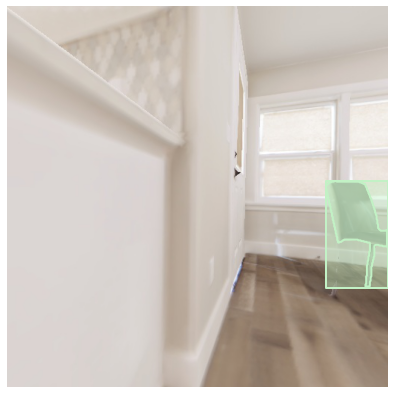

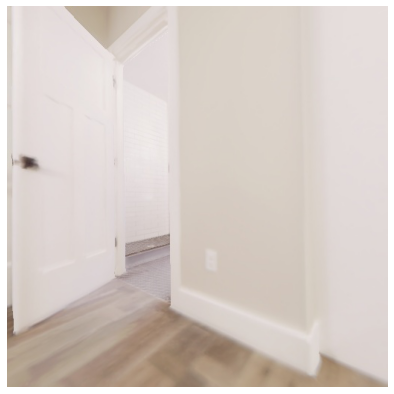

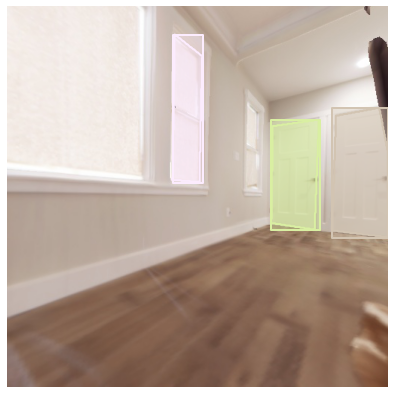

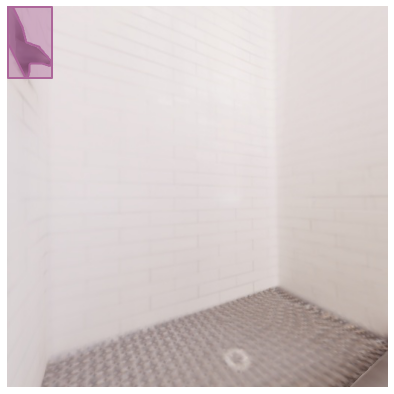

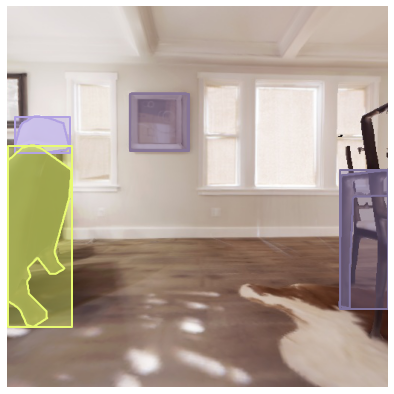

In [57]:
imgIds = coco.getImgIds()
imgs = coco.loadImgs(random.choices(imgIds, k=5))

for x in imgs:
    I = io.imread(os.path.join(images_folder, x['file_name']))
    plt.axis('off')
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=[x['id']])
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns, draw_bbox=True)
    plt.show()